In [20]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [21]:
dataset = '../keypoint_training.csv'
model_save_path = '../keypoint_classifier.hdf5'
tflite_save_path = '../keypoint_classifier.tflite'

In [18]:
NUM_CLASSES = 4

In [22]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [23]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,114 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=../keypoint_classifier.hdf5

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/5 [=====>........................] - ETA: 5s - loss: 1.4517 - accuracy: 0.2891
Epoch 1: saving model to /content/keypoint_classifier.hdf5
5/5 [==============================] - 2s 67ms/step - loss: 1.4300 - accuracy: 0.2722 - val_loss: 1.4374 - val_accuracy: 0.4254
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.4028 - accuracy: 0.3047
Epoch 2: saving model to /content/keypoint_classifier.hdf5
5/5 [==============================] - 0s 19ms/step - loss: 1.3965 - accuracy: 0.3037 - val_loss: 1.4150 - val_accuracy: 0.4365
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.3587 - accuracy: 0.3906
Epoch 3: saving model to /content/keypoint_classifier.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 0s 22ms/step - loss: 1.3717 - accuracy: 0.3426 - val_loss: 1.3798 - val_accuracy: 0.4365
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.3281 - accuracy: 0.4219
Epoch 4: saving model to /content/keypoint_classifier.hdf5
5/5 [==============================] - 0s 23ms/step - loss: 1.3461 - accuracy: 0.3704 - val_loss: 1.3386 - val_accuracy: 0.4365
Epoch 5/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.3524 - accuracy: 0.3516
Epoch 5: saving model to /content/keypoint_classifier.hdf5
5/5 [==============================] - 0s 18ms/step - loss: 1.3367 - accuracy: 0.4000 - val_loss: 1.2979 - val_accuracy: 0.4530
Epoch 6/1000
1/5 [=====>........................] - ETA: 0s - loss: 1.3446 - accuracy: 0.3828
Epoch 6: saving model to /content/keypoint_classifier.hdf5
5/5 [==============================] - 0s 24ms/step - loss: 1.3103 - accuracy: 0.4074 - val_loss: 1.2621 - val_accuracy: 0.7238
Epoch 7/1000
1/5 [=====>.....

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 11ms/step - loss: 0.0650 - accuracy: 0.9834


In [ ]:
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 67ms/step
[9.1985867e-06 9.9882728e-01 4.9497212e-06 1.1585399e-03]
1


6/6 [==============================] - 0s 3ms/step


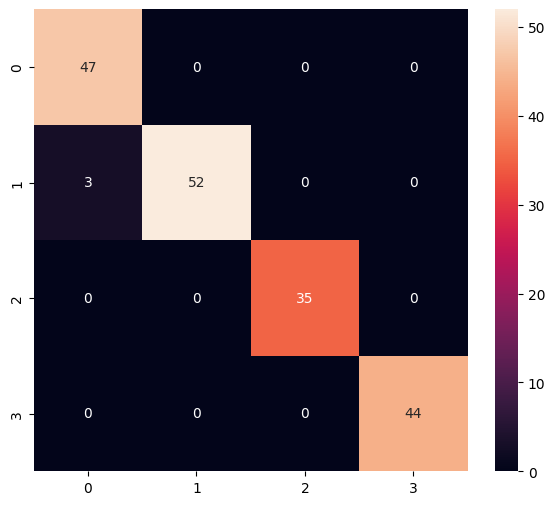

Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        47
           1       1.00      0.95      0.97        55
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        44

    accuracy                           0.98       181
   macro avg       0.98      0.99      0.99       181
weighted avg       0.98      0.98      0.98       181



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6572

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 88 µs, sys: 6 µs, total: 94 µs
Wall time: 100 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.1985858e-06 9.9882728e-01 4.9497216e-06 1.1585399e-03]
1
